In [1]:
%pylab inline

import numpy as np
import pandas as pd

from dataset import load_wiki_traffic_dataset
from itertools import combinations
from sklearn.linear_model import Lasso

from pprint import pprint as pp
from IPython.display import display

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


# Dataset

[Kaggle Web Traffic Time Series Forecasting](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data) 에서 다운로드 받을 수 있습니다.

Training dataset은 145,000개의 time series로 구성되어 있으며, 각각의 time series들은  2015년 7월 1일부터 2016년 12월 31일까지의  서로다른 위키피디아 문서의 daily view의 횟수를 나탄냅니다.<br>


# Configuration

In [2]:
DATA_PATH = '/dataset/web-traffic-forecast/train_1.csv'

# Load Dataset

In [3]:
train = load_wiki_traffic_dataset(DATA_PATH)
sample = train.sample(n=5000)
display(train.head())
train.info()

,page,country,project,access,agent,1,2,3,4,5,...,541,542,543,544,545,546,547,548,549,550
0,2NE1,zh,wikipedia,all-access,spider,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,zh,wikipedia,all-access,spider,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,zh,wikipedia,all-access,spider,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,zh,wikipedia,all-access,spider,35.0,13.0,10.0,94.0,4.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You,zh,wikipedia,all-access,spider,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 555 entries, page to 550
dtypes: float64(550), object(5)
memory usage: 614.2+ MB


## 랜덤 데이터에 대한 plot

In [101]:
sample

,page,country,project,access,agent,1,2,3,4,5,...,541,542,543,544,545,546,547,548,549,550
90303,1_de_mayo,es,wikipedia,all-access,all,328.0,241.0,150.0,160.0,157.0,...,115.0,107.0,248.0,85.0,96.0,100.0,149.0,119.0,101.0,96.0
89605,市立吹田サッカースタジアム,ja,wikipedia,desktop,all,0.0,0.0,0.0,0.0,0.0,...,215.0,211.0,295.0,179.0,177.0,205.0,143.0,382.0,293.0,217.0
22306,Template:Extension/ru,www,mediawiki,mobile-web,all,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0
122497,鳥谷敬,ja,wikipedia,all-access,all,1044.0,876.0,1523.0,1280.0,1075.0,...,634.0,1207.0,595.0,658.0,530.0,616.0,923.0,1093.0,981.0,770.0
114894,Ingwer,de,wikipedia,mobile-web,all,289.0,282.0,305.0,399.0,398.0,...,600.0,638.0,865.0,1002.0,942.0,787.0,798.0,856.0,789.0,795.0
142410,Leyes_de_Reforma,es,wikipedia,all-access,spider,13.0,2.0,7.0,10.0,15.0,...,3.0,8.0,2.0,4.0,3.0,4.0,3.0,162.0,3.0,3.0
3137,春節,zh,wikipedia,all-access,spider,11.0,19.0,10.0,19.0,10.0,...,32.0,41.0,34.0,35.0,28.0,26.0,38.0,40.0,34.0,41.0
86510,断層,ja,wikipedia,desktop,all,108.0,88.0,118.0,75.0,92.0,...,110.0,68.0,46.0,83.0,116.0,80.0,135.0,138.0,72.0,33.0
59964,片山萌美,ja,wikipedia,mobile-web,all,36.0,58.0,41.0,49.0,43.0,...,1151.0,1677.0,2701.0,1919.0,1013.0,608.0,458.0,400.0,450.0,315.0
144333,Imán,es,wikipedia,all-access,spider,5.0,5.0,4.0,10.0,7.0,...,3.0,165.0,8.0,6.0,4.0,6.0,9.0,2.0,5.0,4.0


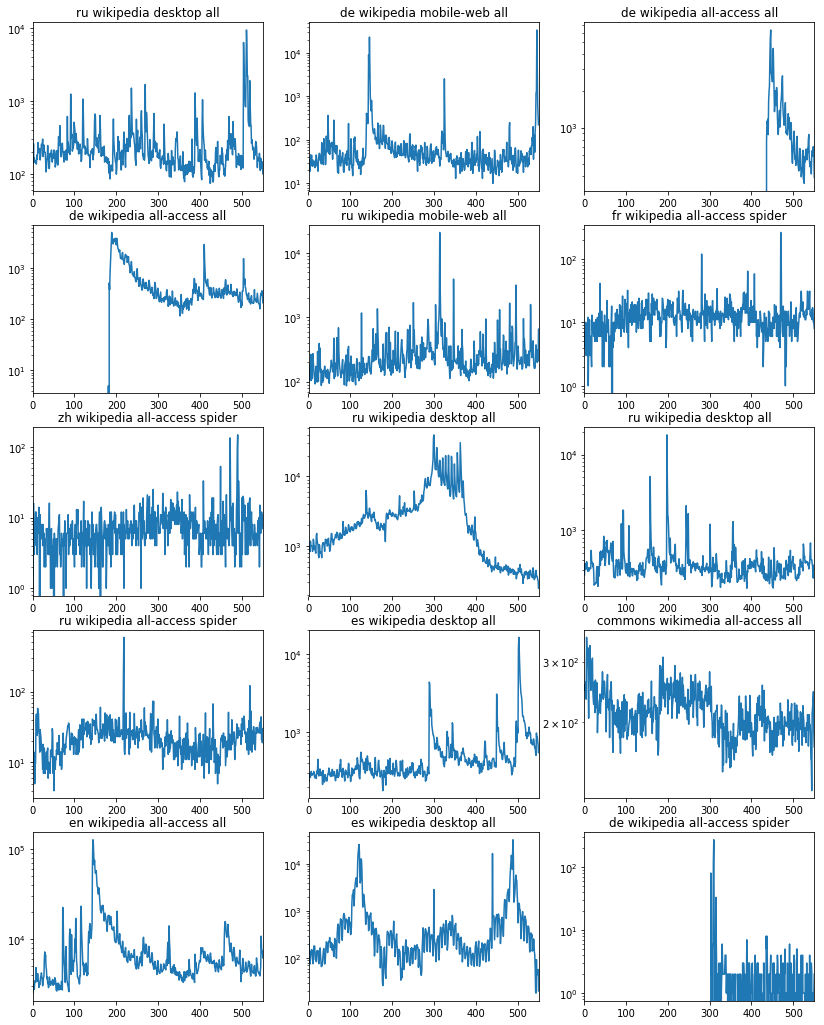

In [88]:
def random_plot(dataset):
    n = dataset.shape[0]
    
    fig, plots = subplots(5, 3)
    plots = plots.reshape(-1)
    fig.set_figheight(18)
    fig.set_figwidth(14)
    
    for p in plots:
        idx = np.random.randint(n)
        row = dataset.iloc[idx]
        title = f"{row['country']} {row['project']} {row['access']} {row['agent']}"
        dataset.iloc[idx, 5:].T.plot(ax=p, logy=True, title=title)
    
random_plot(train)

## 전체 데이터셋의 트렌드

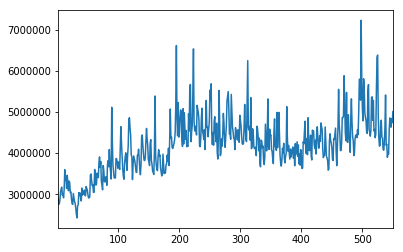

In [100]:
sample.iloc[:, 5:].sum(axis=0).plot()

# 국가별 분석

## 국가별 데이터 히스토그램

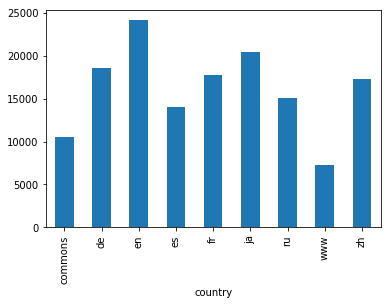

In [4]:
train.groupby('country')['country'].count().plot(kind='bar')

## 국가별 트렌드

country,commons,de,en,es,fr,ja,ru,www,zh
country,,,,,,,,,
commons,1.000000,0.043355,0.374597,0.197975,0.289372,0.306744,0.049741,0.186837,0.438006
de,0.043355,1.000000,0.154222,0.300227,0.586279,0.337375,0.057187,0.060339,0.392841
en,0.374597,0.154222,1.000000,0.101900,0.284672,0.386656,0.799605,0.058430,0.534174
es,0.197975,0.300227,0.101900,1.000000,0.290677,0.013924,0.005300,0.158443,0.113134
fr,0.289372,0.586279,0.284672,0.290677,1.000000,0.476908,0.147278,0.150433,0.588744
ja,0.306744,0.337375,0.386656,0.013924,0.476908,1.000000,0.196398,0.186209,0.684289
ru,0.049741,0.057187,0.799605,0.005300,0.147278,0.196398,1.000000,0.008254,0.273804
www,0.186837,0.060339,0.058430,0.158443,0.150433,0.186209,0.008254,1.000000,0.155146
zh,0.438006,0.392841,0.534174,0.113134,0.588744,0.684289,0.273804,0.155146,1.000000


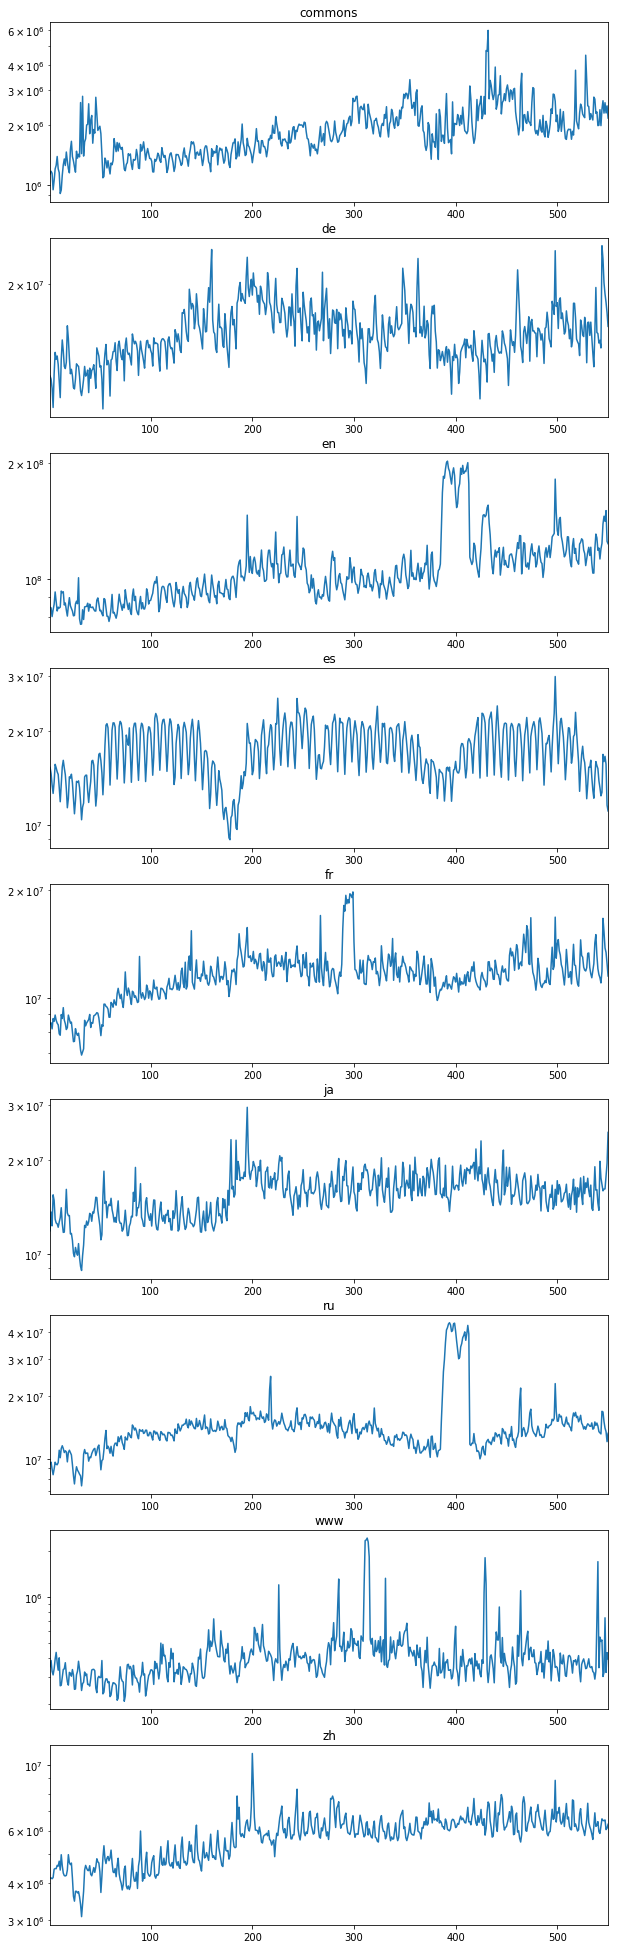

In [38]:
def group(dataset, column_name):
    return dataset.groupby(column_name).sum(axis=1).iloc[:, 4:].T
    
def trend(dataset, height:int, width:int=10):
    fig, plots = subplots(len(dataset.columns), 1)
    fig.set_figheight(height)
    fig.set_figwidth(width)

    for p, c in zip(plots, dataset.columns):
        dataset[c].plot(ax=p, logy=True, label=c)
        p.set_title(c)

countries = group(train, 'country')
display(countries.corr())
trend(countries, 35)

## 국가별 상관관계및 Scatter Plots

In [36]:
# country_combinations = list(combinations(countries.columns, r=2))
# fig, plots = subplots(len(country_combinations), 1)
# fig.set_figheight(150)

# for p, (c1, c2) in zip(plots, country_combinations):
#     countries.plot.scatter(c1, c2, ax=p)

# Access 분석

access,all-access,desktop,mobile-web
access,,,
all-access,1.000000,0.932431,0.537284
desktop,0.932431,1.000000,0.213871
mobile-web,0.537284,0.213871,1.000000


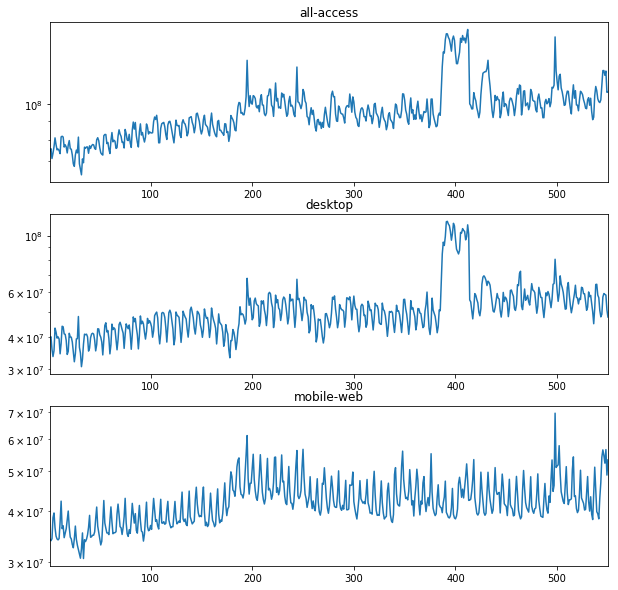

In [39]:
accesses = group(train, 'access')
display(accesses.corr())
trend(accesses, 10)

## Lagged Correlation

In [29]:
dataset.shift(-5)['active_power']

datetime
2010-10-27 13:40:00    0.522
2010-10-27 13:41:00    0.520
2010-10-27 13:42:00    0.518
2010-10-27 13:43:00    0.520
2010-10-27 13:44:00    0.518
2010-10-27 13:45:00    0.518
2010-10-27 13:46:00    0.520
2010-10-27 13:47:00    0.522
2010-10-27 13:48:00    0.542
2010-10-27 13:49:00    0.624
2010-10-27 13:50:00    0.622
2010-10-27 13:51:00    0.618
2010-10-27 13:52:00    0.616
2010-10-27 13:53:00    0.614
2010-10-27 13:54:00    0.614
2010-10-27 13:55:00    0.612
2010-10-27 13:56:00    0.610
2010-10-27 13:57:00    0.610
2010-10-27 13:58:00    0.610
2010-10-27 13:59:00    0.610
2010-10-27 14:00:00    0.612
2010-10-27 14:01:00    0.598
2010-10-27 14:02:00    0.516
2010-10-27 14:03:00    0.514
2010-10-27 14:04:00    0.514
2010-10-27 14:05:00    0.550
2010-10-27 14:06:00    0.590
2010-10-27 14:07:00    0.592
2010-10-27 14:08:00    0.592
2010-10-27 14:09:00    0.588
                       ...  
2010-11-26 19:28:00    1.870
2010-11-26 19:29:00    1.864
2010-11-26 19:30:00    2.754
2010-